In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pyBigWig as bw
import pyranges as pr
import os
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import warnings
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import sys
sys.path.append("/scratch/eli")
from perturbseq import *

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['pdf.fonttype'] = 42

In [5]:
gtf = pr.read_gtf('/fscratch/eli/genomes/refdata-gex-GRCh38-2020-A/genes/genes.gtf')

/home/metznere/.conda/envs/scenv/lib/python3.11/site-packages/pyranges/methods/init.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return {k: v for k, v in df.groupby(grpby_key)}


In [ ]:
pop = CellPopulation.from_hdf("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files/gex_norm_regressed.hdf5")
adata = sc.read_10x_h5("/data/norman/eli/T7/202404_SIRLOIN_multiome/Lane1_040/outs/filtered_feature_bc_matrix.h5")
adata = adata[adata.obs.index.isin(pop.cells.index), adata.var_names.isin(pop.genes.index)]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

df_expr = adata.to_df().join(pop.cells.guide_identity)
df_expr['complex'] = pd.Categorical(df_expr.guide_identity.map(lambda g: 'NuA4' if g in ['EP400', 'DMAP1', 'ACTL6A'] else 'NTC' if g == 'NTC' else 'Poly' if g in ['SUZ12', 'EZH2', 'YY1'] else 'BAF'), categories = ['NuA4', 'BAF', 'Poly', 'NTC'], ordered = True)

In [8]:
pop = CellPopulation.from_hdf("/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/intermediate_files/gex_norm_regressed.hdf5")
df_expr = pop.matrix.join(pop.cells.guide_identity)
df_expr['complex'] = pd.Categorical(df_expr.guide_identity.map(lambda g: 'NuA4' if g in ['EP400', 'DMAP1', 'ACTL6A'] else 'NTC' if g == 'NTC' else 'Poly' if g in ['SUZ12', 'EZH2', 'YY1'] else 'BAF'), categories = ['NuA4', 'BAF', 'Poly', 'NTC'], ordered = True)

Loading matrix...
Loading metadata...
Done in 0.9254114627838135s.
Generating summary statistics...
Done.


In [2]:
def plot_genomic_region(chrm, start, end, ax):
    
    """
    Adapted from https://github.com/snehamitra/SCARlink/blob/main/scarlink/src/plotExtra.py
    """
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df_region = gtf.df.query(f"Chromosome == '{chrm}' and Start <= {end} and End >= {start} and gene_type == 'protein_coding'")

        transcripts = {}
        for i, r in df_region.iterrows():
            if r.Feature == 'transcript' and r[11].find('.') == -1 and r.transcript_type == 'protein_coding':
                gene = r[11]
                if r[6] == '+':
                    ax.add_patch(patches.Rectangle((r[3], 0.45), r[4] - r[3] + 1, 0.2, color = sns.color_palette("icefire",8)[0]))
                else:
                    ax.add_patch(patches.Rectangle((r[3], -0.65), r[4] - r[3] + 1, 0.2, color = sns.color_palette("icefire",10)[-1]))
                if gene not in transcripts:
                    transcripts[gene] = (r[3], r[4], r[6])
                else:
                    transcripts[gene] = (min(r[3], transcripts[gene][0]), max(r[4], transcripts[gene][1]), r[6])
            elif r[2] == 'exon' and r[11].find('.') == -1 and r.transcript_type == 'protein_coding': 
  
                gene = r[11]
                if r[6] == '+':
                    ax.add_patch(patches.Rectangle((r[3], 0.1), r[4] - r[3] + 1, 0.9, color = sns.color_palette("icefire",8)[0]))
                else:
                    ax.add_patch(patches.Rectangle((r[3], -1), r[4] - r[3] + 1, 0.9, color = sns.color_palette("icefire",8)[-1]))
            
        for t in transcripts:
            if transcripts[t][2] == '+':
                if transcripts[t][0] > start:
                    ax.text(transcripts[t][0] + 10, 1.2, t, style = 'italic')
                else:
                    ax.text(start + 10, 1.2, t, style = 'italic')
            else:
                if transcripts[t][0] > start:
                    ax.text(transcripts[t][0] + 10, -3, t, style = 'italic')
                else:
                    ax.text(start, -3, t, style = 'italic')

        ax.set_xlim((start, end))
        ax.set_ylim((-1.9, 1.9))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False) # new
        ax.spines['right'].set_visible(False) # new
        ax.spines['left'].set_visible(False) # new
        ax.spines['bottom'].set_visible(False) # new

In [17]:
def plot_autogluon_result(gene, locus = None, atac_window = 20, savefig = False, scale_feature_importance = False, feature_vmax = None, tick_window = 100, vlim = (-2,2)):

    # get feature importance
    df = pd.read_csv(f"/scratch/eli/AutogluonModels/scaled/{gene}_feature_importance.csv", index_col = 0)
    df = df.sort_values(["importance", "Overlap"], ascending = False).reset_index()
    df['feature_id'] = df.apply(lambda df: df.iloc[0] if type(df.Chromosome) is float else f"{str(df.Chromosome)}:{str(int(df.Start))}-{str(int(df.End))}", axis = 1)
    df = df.drop('index', axis = 1).set_index('feature_id')
    df_filtered = df.reset_index().drop_duplicates('feature_id', keep = 'first')
    df_filtered = df_filtered.query("feature_id.str.startswith('chr')").sort_values("feature_id")
    df_filtered['adjusted_importance'] = df_filtered.apply(lambda df: df.importance if df.fdr < 0.1 and df.importance >=0 else 0, axis = 1)
    if scale_feature_importance:
        scaler = StandardScaler()
        df_filtered['adjusted_importance'] = scaler.fit_transform(df_filtered['adjusted_importance'].to_numpy().reshape(-1, 1))

    # define locus
    if locus is None:
        chrom = df_filtered.iloc[0,:].Chromosome
        start = int(df_filtered.iloc[0,:].Start)
        end = int(df_filtered.iloc[-1,:].End)
    else:
        chrom, start, end = locus

    # make relevant dfs for plotting
    df_heatmap = df_filtered[['Start', 'End', 'adjusted_importance']].query("Start >= @start and End <= @end").set_index("Start").drop("End", axis = 1).T
    df_cre = df_filtered[['Start', 'End', 'reg']].query("Start >= @start and End <= @end").set_index("Start").drop("End", axis = 1)
    df_cre.index = df_cre.index.astype(int) / 1000

    # get bigwig coverage
    df_coverage = pd.DataFrame({'bp': np.arange(start, end)})
    for file in os.scandir("intermediate_files/atac_coverage"):
        if file.name.endswith(".bw"):
            coverage = bw.open(file.path)
            df_coverage[file.name.split(".")[0]] = coverage.values(chrom, start, end)
    df_coverage_rolling = df_coverage.iloc[::atac_window,:]

    cdict = dict(zip(df_coverage_rolling.columns[1:], ['#357ba3', '#3e356b', '#4bc2ad', '#357ba3', '#bbbbbb', '#3e356b', '#357ba3', '#357ba3', '#4bc2ad','#357ba3', '#4bc2ad', '#3e356b','#357ba3', '#357ba3']))

    # get expression
    sorted_expr = df_expr[[gene, 'guide_identity']].copy().groupby("guide_identity").median().sort_values(gene, ascending = False)
    order = sorted_expr.index.tolist()

    reg_color_dict = {'enhP':'#86c769', 'enhD':'#558f8c', 'prom':'#f7e642', 'CTCF': '#444684', 'K4m3': '#c0df25', '-1':'#ffffff'}
    cmap = ListedColormap(reg_color_dict.values())
    reg_color_dict = dict(zip(reg_color_dict.keys(), np.arange(len(reg_color_dict.keys()))))
    df_cre = df_cre.replace(reg_color_dict).T

    # make plot
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(17,2, height_ratios = [5 for i in range(14)] + [2, 1.5, 0.75], width_ratios=[6,1], wspace = 0)
    axes  = []
    for i, tgt in enumerate(order):
        ax = fig.add_subplot(gs[i,0])
        sns.lineplot(df_coverage_rolling, x = 'bp', y = tgt, ax = ax, linewidth = 2, color = cdict[tgt],)
        ax.text(s = tgt, x = 0.01, y = 0.75, fontsize = 12, fontweight = 'bold', color = cdict[tgt], transform=ax.transAxes)
        ax.set_ylabel('')
        axes.append(ax)

    ax_v = fig.add_subplot(gs[0:14,1])
    sns.violinplot(data = df_expr, y='guide_identity', x = gene, hue = 'complex', palette = sns.color_palette("mako", 3) + ['#bbbbbb'], alpha = 0.8, orient = 'h', ax = ax_v, legend = False, order = order,cut=0)
    ax_v.axvline(0, color = 'grey', linestyle = '--')

    ax_features = fig.add_subplot(gs[14,0])
    sns.heatmap(df_heatmap, ax = ax_features, cmap = 'PuRd', cbar = False, vmax = feature_vmax, vmin = 0)

    ax_genes = fig.add_subplot(gs[15,0])
    plot_genomic_region(chrom, start, end, ax_genes)

    ax_cre = fig.add_subplot(gs[16,0])
    sns.heatmap(df_cre, ax = ax_cre, cmap = cmap, cbar = False)

    for ax in axes:
        ax.set_xlim(start, end)
        ax.set_xticks([])
        ax.set_xlabel('')
        ax.set_ylim(0,df_coverage.drop("bp", axis = 1).max().max())
        ax.set_yticks([])
        sns.despine(ax = ax)

    ax_features.axis('off')
    ax_genes.axis('off')
    
    ax_v.get_yaxis().set_visible(False)
    ax_v.spines['left'].set_visible(False)
    ax_v.spines['top'].set_visible(True)
    ax_v.spines['bottom'].set_visible(False)
    ax_v.spines['right'].set_visible(False)
    ax_v.xaxis.set_ticks_position('top')
    ax_v.xaxis.set_label_position('top')
    ax_v.set_xlabel("Z-norm. expr.")
    ax_v.set_xlim(vlim)

    ticks = df_cre.columns[::tick_window]
    tick_positions = np.arange(0, df_cre.shape[1], tick_window)
    ax_cre.set_xticks(tick_positions)
    ax_cre.set_xticklabels([f'{int(x):,}' for x in ticks], rotation = 0)
    ax_cre.set_xlabel(f"Chromosome {chrom.split('r')[1]} (kb)")
    ax_cre.spines['bottom'].set_visible(True)

    # sns.despine()
    if savefig:
        plt.savefig(os.path.join(savefig, f"{gene}_autogluon.pdf"), transparent = True)
    plt.show()

/tmp/ipykernel_444060/2990765378.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cre = df_cre.replace(reg_color_dict).T


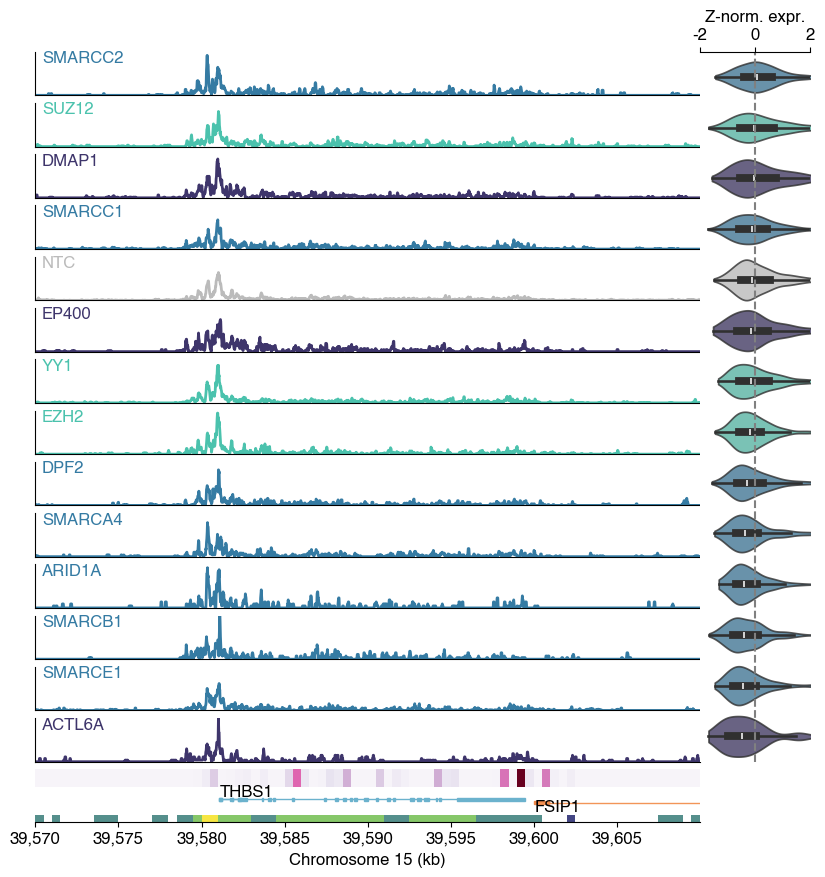

In [18]:
plot_autogluon_result('THBS1', ('chr15',39570000, 39610000), scale_feature_importance=True, atac_window = 20, tick_window = 10)#, savefig = "/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs")

/tmp/ipykernel_444060/2990765378.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cre = df_cre.replace(reg_color_dict).T


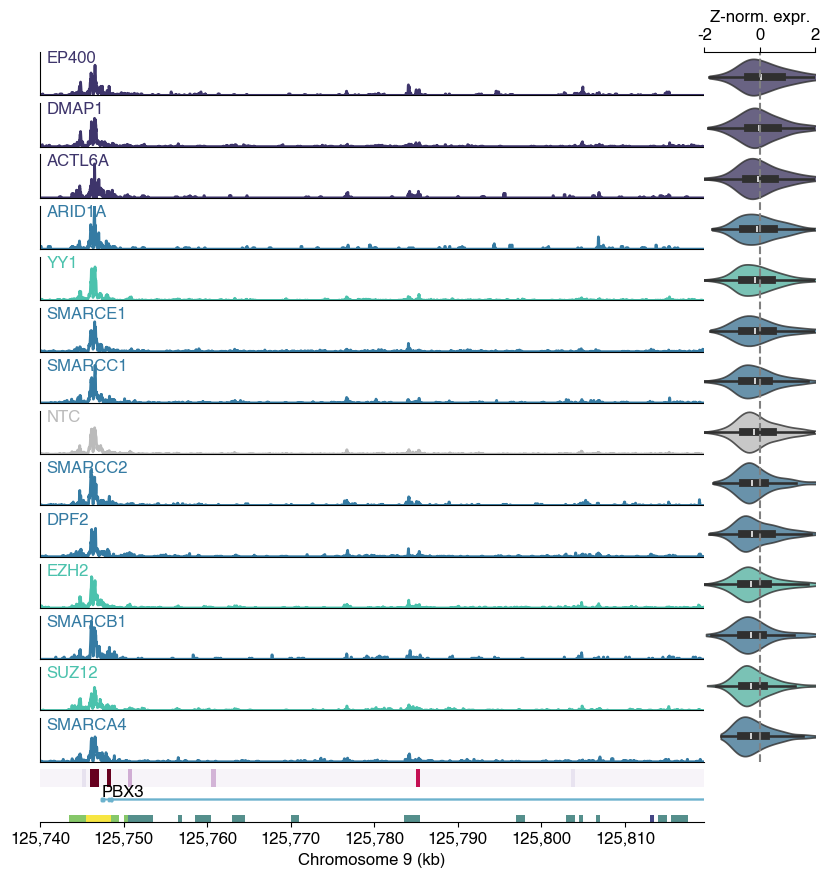

In [19]:
plot_autogluon_result('PBX3', ('chr9', 125740000, 125820000), scale_feature_importance=True, feature_vmax=2, tick_window = 20, vlim = (-2,2))#, savefig = "/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs")

/tmp/ipykernel_502913/3234059355.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cre = df_cre.replace(reg_color_dict).T


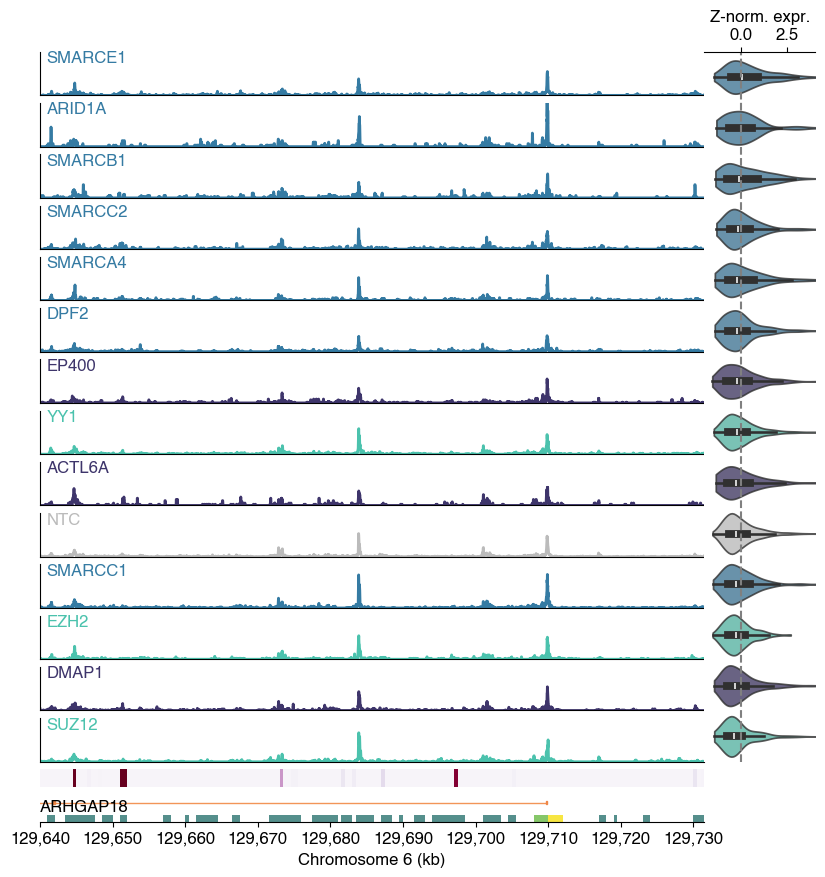

In [37]:
plot_autogluon_result('ARHGAP18',('chr6', 129640000, 129732000), scale_feature_importance = True, feature_vmax = 2, tick_window = 20, vlim = (-2,4), savefig = '/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs')

/tmp/ipykernel_502913/3234059355.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cre = df_cre.replace(reg_color_dict).T
webf NOT subset; don't know how to subset; dropped


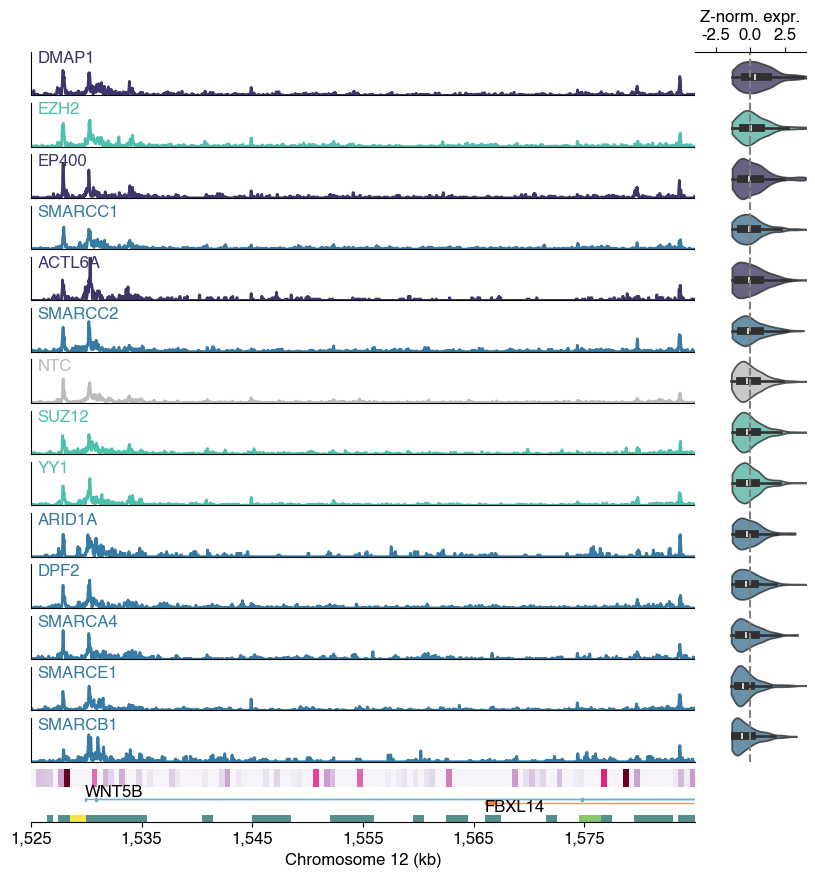

In [40]:
plot_autogluon_result('WNT5B', ('chr12', 1525000, 1585000), scale_feature_importance = True, feature_vmax = 2, tick_window = 20, vlim = (-4,4), savefig = "/data/norman/eli/T7/202404_SIRLOIN_multiome/figs/revision/outs")